# Seasonal Trend Decomp To Detect Trends

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from pathlib import Path
import numpy as np
import glob

# Get all CSV file paths from the "aqicn_data" directory
data_folder = Path("aqicn_data")
cities = list(data_folder.glob("*.csv"))

PERIOD = 365     # daily data → yearly seasonality
MIN_YEARS = 2       # require ≥2 years for STL to be meaningful

def load_data(filepath):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df.sort_values("date").reset_index(drop=True)

def stl_trend(df, pollutant):
    series = df[["date", pollutant]].dropna()
    if len(series) < PERIOD * MIN_YEARS:
        return pd.Series(dtype=float)

    ts = (series.set_index("date")[pollutant]
          .asfreq("D")                          # enforce daily spacing
          .interpolate(limit_direction="both")) # fill gaps

    return STL(ts, period=PERIOD, robust=True).fit().trend

def slope_per_year(trend):
    if trend.empty:
        return float("nan")
    x = (trend.index - trend.index[0]).days / 365.2425
    coeff, _ = np.polyfit(x, trend.values, 1)
    return coeff

def analyse_city(filepath: str):
    city = Path(filepath).stem.capitalize()
    df   = load_data(filepath)
    pollutants = [c for c in df.columns if c != "date"]

    if not pollutants:
        print(f"{city}: no pollutant columns found — skipping.")
        return

    # ---------- plotting ----------
    plt.figure(figsize=(12, 6))
    slope_records = []

    for pol in pollutants:
        trend = stl_trend(df, pol)
        if trend.empty:
            continue
        plt.plot(trend.index, trend, label=pol)
        slope_records.append(
            {"pollutant": pol,
             "slope_per_year": slope_per_year(trend)}
        )

    if not slope_records:
        print(f"{city}: insufficient data for STL decomposition.")
        return

    plt.title(f"{city} – Trend of pollutants (STL)")
    plt.xlabel("Date")
    plt.ylabel("Concentration (trend component)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- numeric trend table ----------
    slopes_df = (pd.DataFrame(slope_records)
                 .sort_values("slope_per_year", ascending=False)
                 .reset_index(drop=True))
    print(f"\n{city} – Annual slope of STL trend (+ up, – down):")
    print(slopes_df.to_string(index=False, float_format="%.2f"))
    print("-" * 60)

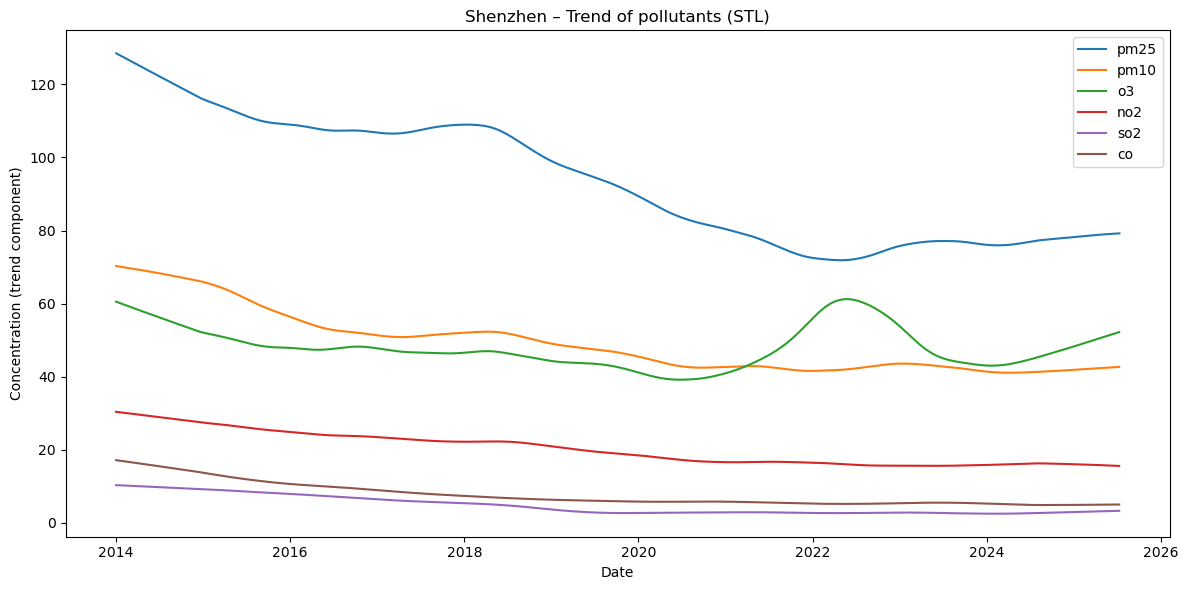


Shenzhen – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3           -0.28
      so2           -0.67
       co           -0.84
      no2           -1.26
     pm10           -2.27
     pm25           -4.72
------------------------------------------------------------


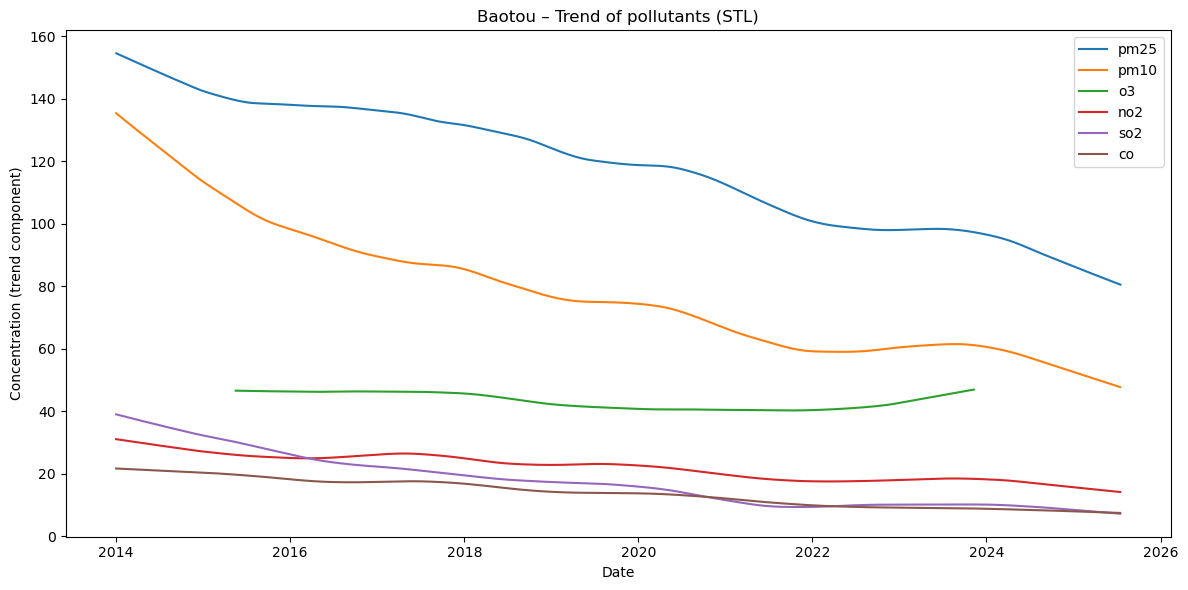


Baotou – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3           -0.65
      no2           -1.20
       co           -1.28
      so2           -2.41
     pm25           -5.82
     pm10           -6.01
------------------------------------------------------------


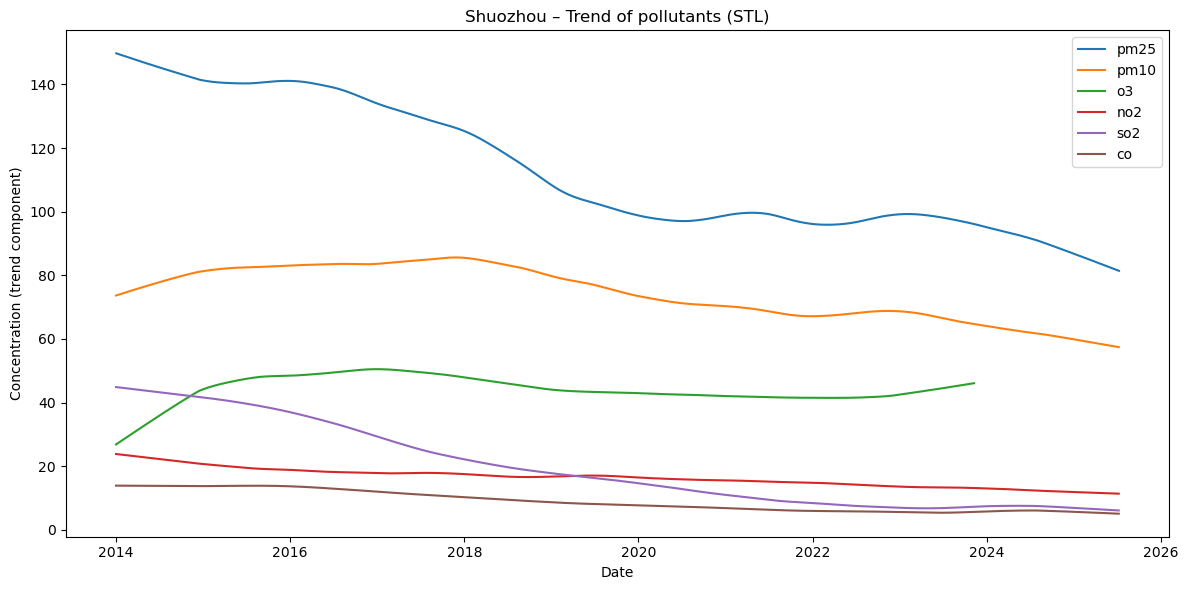


Shuozhou – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3           -0.13
      no2           -0.85
       co           -0.92
     pm10           -2.20
      so2           -3.67
     pm25           -5.80
------------------------------------------------------------


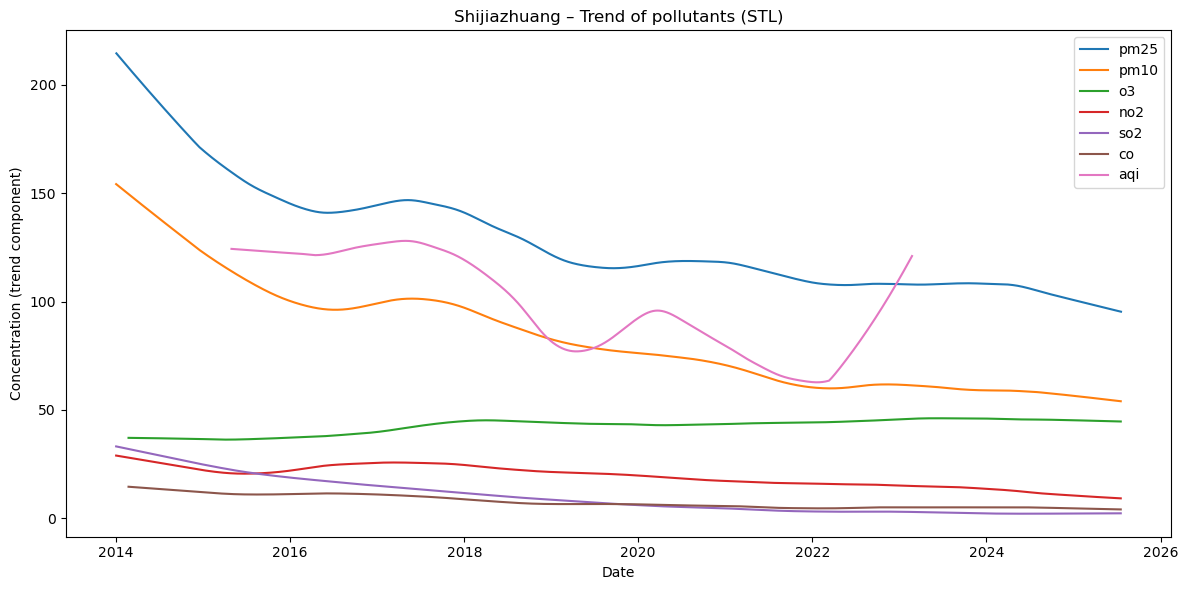


Shijiazhuang – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3            0.86
       co           -0.84
      no2           -1.35
      so2           -2.35
     pm10           -6.96
     pm25           -7.08
      aqi           -7.69
------------------------------------------------------------


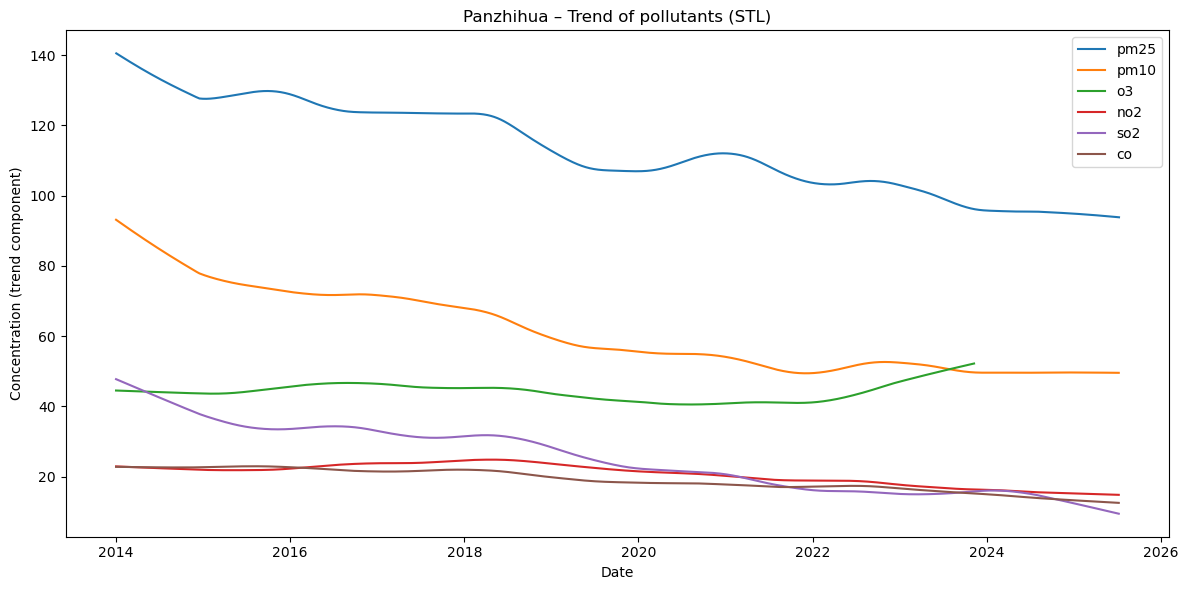


Panzhihua – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3           -0.03
      no2           -0.77
       co           -0.91
      so2           -2.77
     pm10           -3.28
     pm25           -3.73
------------------------------------------------------------


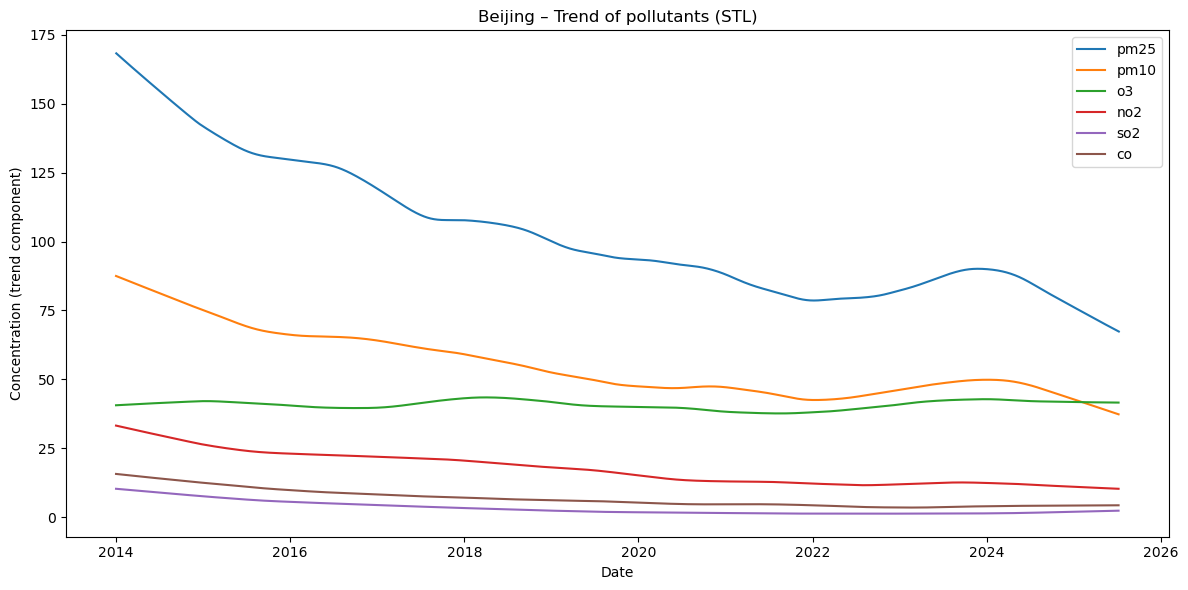


Beijing – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3           -0.02
      so2           -0.61
       co           -0.87
      no2           -1.69
     pm10           -3.23
     pm25           -6.68
------------------------------------------------------------


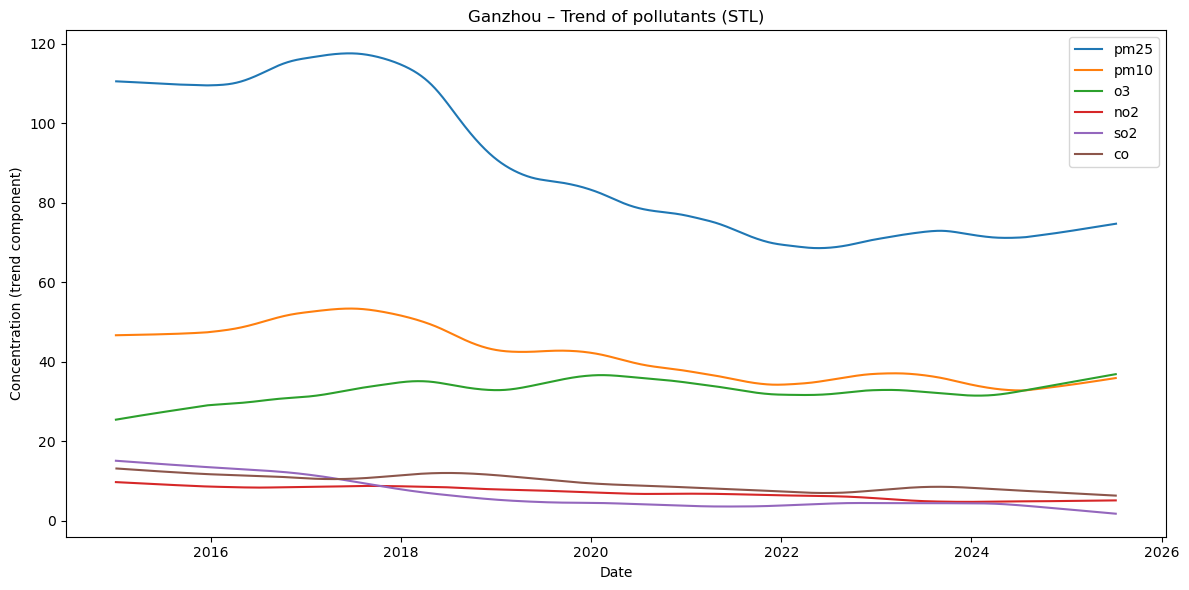


Ganzhou – Annual slope of STL trend (+ up, – down):
pollutant  slope_per_year
       o3            0.39
      no2           -0.48
       co           -0.57
      so2           -1.10
     pm10           -1.97
     pm25           -5.42
------------------------------------------------------------


In [ ]:
for city in cities:
    if not Path(city).exists():
        print(f"{city} not found — skipping.")
        continue
    analyse_city(city)